# Let's build the **simple autoencoder**



We'll start simple, with a single fully-connected neural layer as encoder and as decoder:


In [6]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  
# Input Image size = #28*28 = 784 /32=24.5 

# This is our input_image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model:

In [7]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [8]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [9]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.



In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 3s 10ms/step - loss: 0.2781 - val_loss: 0.1886
Epoch 2/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1695 - val_loss: 0.1524
Epoch 3/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1433 - val_loss: 0.1331
Epoch 4/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1285 - val_loss: 0.1219
Epoch 5/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1193 - val_loss: 0.1145
Epoch 6/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1128 - val_loss: 0.1089
Epoch 7/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1079 - val_loss: 0.1044
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1039 - val_loss: 0.1010
Epoch 9/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1008 - val_loss: 0.0982
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0984 - val_loss: 0.0

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [12]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

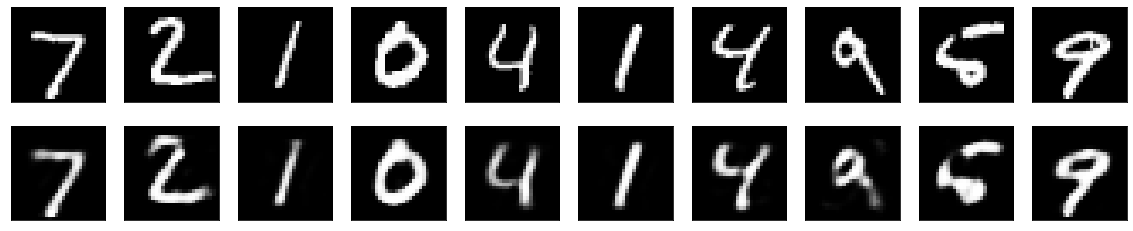

In [13]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

Adding a sparsity constraint on the encoded representations
In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [14]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

Here's a visualization of our new results:
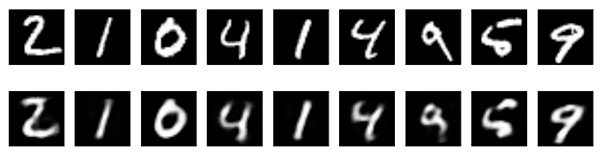

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 3.33 (over our 10,000 test images), whereas with the previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.


Deep autoencoder
We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [15]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [16]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 4s 15ms/step - loss: 0.2520 - val_loss: 0.1720
Epoch 2/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1534 - val_loss: 0.1373
Epoch 3/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1323 - val_loss: 0.1262
Epoch 4/100
235/235 [==============================] - 3s 15ms/step - loss: 0.1246 - val_loss: 0.1199
Epoch 5/100
235/235 [==============================] - 3s 15ms/step - loss: 0.1191 - val_loss: 0.1149
Epoch 6/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1144 - val_loss: 0.1116
Epoch 7/100
235/235 [==============================] - 3s 15ms/step - loss: 0.1112 - val_loss: 0.1083
Epoch 8/100
235/235 [==============================] - 3s 15ms/step - loss: 0.1087 - val_loss: 0.1070
Epoch 9/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1068 - val_loss: 0.1044
Epoch 10/100
235/235 [==============================] - 3s 15ms/step - loss: 0.105

# ***Convolutional autoencoder***
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [17]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [18]:


from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [19]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 70s 147ms/step - loss: 0.2150 - val_loss: 0.1483
Epoch 2/50
469/469 [==============================] - 67s 143ms/step - loss: 0.1397 - val_loss: 0.1306
Epoch 3/50
469/469 [==============================] - 67s 144ms/step - loss: 0.1267 - val_loss: 0.1214
Epoch 4/50
469/469 [==============================] - 67s 144ms/step - loss: 0.1191 - val_loss: 0.1151
Epoch 5/50
469/469 [==============================] - 67s 143ms/step - loss: 0.1145 - val_loss: 0.1114
Epoch 6/50
469/469 [==============================] - 67s 143ms/step - loss: 0.1114 - val_loss: 0.1090
Epoch 7/50
469/469 [==============================] - 67s 143ms/step - loss: 0.1093 - val_loss: 0.1071
Epoch 8/50
469/469 [==============================] - 68s 144ms/step - loss: 0.1076 - val_loss: 0.1055
Epoch 9/50
469/469 [==============================] - 67s 144ms/step - loss: 0.1062 - val_loss: 0.1042
Epoch 10/50
469/469 [==============================] - 67s 144ms/step - l

The model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

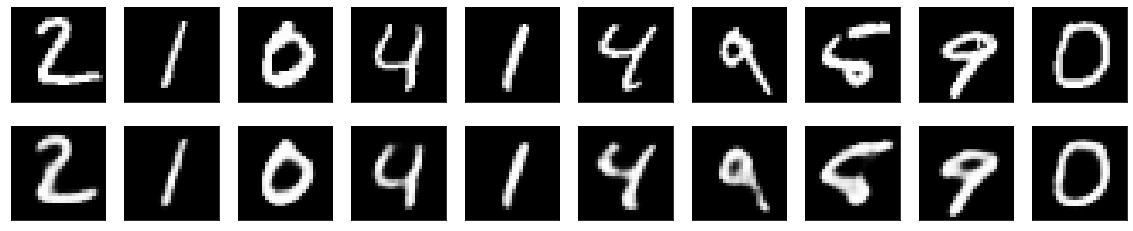

In [20]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.



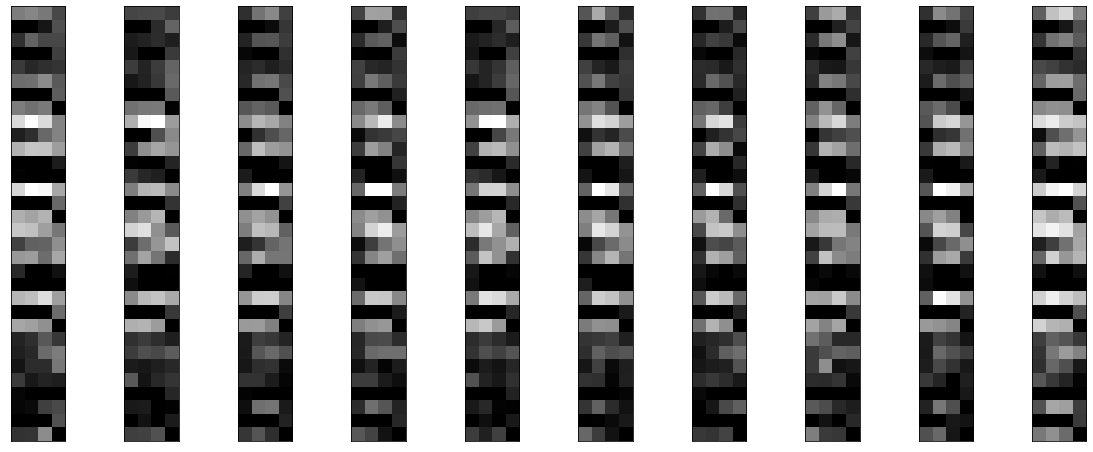

In [21]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **Application to image denoising**
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [22]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's what the noisy digits look like:


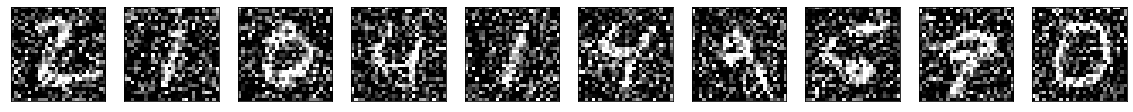

In [23]:

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
#Let's train it for 100 epochs:

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 137s 291ms/step - loss: 0.1600 - val_loss: 0.1165
Epoch 2/100
469/469 [==============================] - 137s 292ms/step - loss: 0.1131 - val_loss: 0.1099
Epoch 3/100
469/469 [==============================] - 139s 297ms/step - loss: 0.1073 - val_loss: 0.1046
Epoch 4/100
469/469 [==============================] - 137s 293ms/step - loss: 0.1044 - val_loss: 0.1027
Epoch 5/100
469/469 [==============================] - 139s 296ms/step - loss: 0.1025 - val_loss: 0.1010
Epoch 6/100
469/469 [==============================] - 138s 294ms/step - loss: 0.1012 - val_loss: 0.0997
Epoch 7/100
469/469 [==============================] - 137s 292ms/step - loss: 0.1003 - val_loss: 0.0991
Epoch 8/100
469/469 [==============================] - 141s 300ms/step - loss: 0.0994 - val_loss: 0.0981
Epoch 9/100
469/469 [==============================] - 136s 291ms/step - loss: 0.0988 - val_loss: 0.0978
Epoch 10/100
469/469 [==============================] -

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

denoised digits
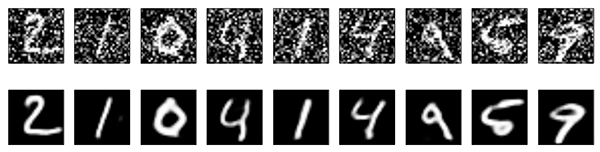